In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os

os.environ['__NV_PRIME_RENDER_OFFLOAD'] = '1'
os.environ['__GLX_VENDOR_LIBRARY_NAME'] = 'nvidia'
os.environ['MUJOCO_GL'] = 'egl'

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

import mujoco
from datetime import datetime
from functools import partial
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo

from IPython.display import  clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from tqdm import tqdm
np.set_printoptions(precision=3, suppress=True, linewidth=100)


In [2]:

import balance
env = partial(balance.G1Env)()
env_cfg = balance.default_config()

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state]

f = 0.5

for i in tqdm(range(200)):
  action = []
  for j in range(env.action_size):

    if env.mj_model.actuator(j).name == "right_knee_joint" or env.mj_model.actuator(j).name == "left_shoulder_roll_joint":
      value = jp.sin(
            state.data.time * 2 * jp.pi * f 
        ) * 1.
    else:
      value = 0.
      
    action.append( value)
  action = jp.array(action)
  state = jit_step(state, action)
  rollout.append(state)
frames = env.render(rollout, camera="track")
media.show_video(frames, fps=1.0 / env.dt)

/home/logan/miniconda3/envs/g1/lib/python3.10/site-packages/jax/_src/interpreters/xla.py:132: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
100%|██████████| 201/201 [00:16<00:00, 12.24it/s]


In [3]:
from ml_collections import config_dict
# ppo_params= config_dict.create(
#     num_timesteps=1_000_000,
#     num_evals=10,
#     reward_scaling=10.0,
#     episode_length=env_cfg.episode_length,
#     normalize_observations=True,
#     action_repeat=1,
#     unroll_length=30,
#     num_minibatches=32,
#     num_updates_per_batch=16,
#     discounting=0.995,
#     learning_rate=1e-3,
#     entropy_cost=1e-2,
#     num_envs=2048,
#     batch_size=1024,
# )

from ml_collections import config_dict
ppo_params= config_dict.create(
    num_timesteps=1_000_000,
    num_evals=10,
    reward_scaling=10.0,
    episode_length=env_cfg.episode_length,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=30,
    num_minibatches=32,
    num_updates_per_batch=16,
    discounting=0.995,
    learning_rate=1e-3,
    entropy_cost=1e-2,
    num_envs=2048,
    batch_size=1024,
)
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.ylim([0, 1100])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress
)

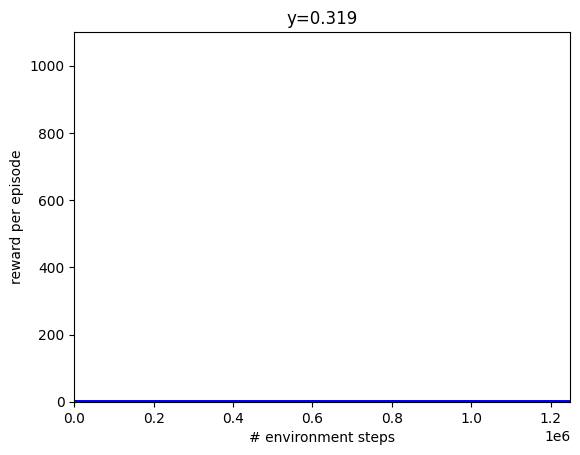

time to jit: 0:01:43.052571
time to train: 0:07:48.816246


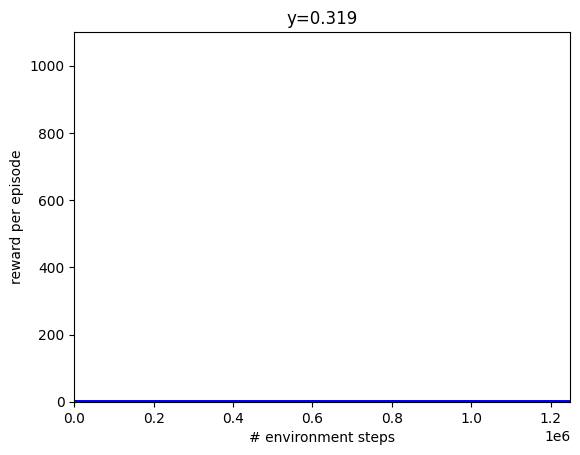

In [4]:
from mujoco_playground import wrapper

make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")
# ~6m11s

In [5]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)
# ~11s

100%|██████████| 1001/1001 [01:09<00:00, 14.35it/s]
